### Chapter 6: Classifying Activity Type

In [1]:
# import modules
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

In [2]:
# set data directory file path
path = 'data/activities'

In [3]:
# create a function that uses pytorch utilities to load and
# transform images, and make training and testing sets
def load(path, size = 0.2):
    t = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])
    train = datasets.ImageFolder(path, transform=t)
    test = datasets.ImageFolder(path, transform=t)
    n = len(train)
    indices = list(range(n))
    split = int(np.floor(size * n))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

['surfing', 'tennis']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


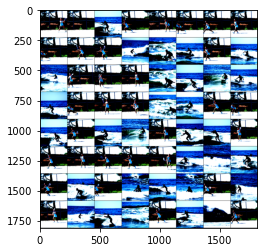

In [4]:
# load images of surfers and tennis players
trainloader, testloader = load(path, 0.2)
print(trainloader.dataset.classes)
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.permute(1, 2, 0));

#### Project 6-1: Classifying Activity Type

In [5]:
# specify pytorch use CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

In [7]:
# freeze gradients since the model is already trained
for param in model.parameters():
    param.requires_grad = False

In [8]:
# use ConvNet as a fixed feature extractor by removing the last fully
# connected layer of the pretrained model and replace it with a linear
# classifier for the 2 classes we need, surfing and tennis
features = model.fc.in_features
model.fc = nn.Linear(features, len(labels))
model = model.to(device)

# instantiate the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
# create a function that trains the model
def train_model(epochs=3):
    total_loss = 0
    train_losses, test_losses = [], []
    i = 0
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            i += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            total_loss = loss.item()
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(total_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            print(f"Epoch {epoch + 1} / {epochs}.. "
                  f"Train loss: {total_loss:.3f}.. "
                  f"Test loss: {test_loss / len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy / len(testloader):.3f}")
            running_loss = 0
            model.train()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.legend(frameon=False)
    return model

Epoch 1 / 5.. Train loss: 4.018.. Test loss: 4.034.. Test accuracy: 0.000
Epoch 1 / 5.. Train loss: 3.798.. Test loss: 3.652.. Test accuracy: 0.100
Epoch 1 / 5.. Train loss: 3.469.. Test loss: 3.136.. Test accuracy: 0.500
Epoch 2 / 5.. Train loss: 2.938.. Test loss: 2.523.. Test accuracy: 0.650
Epoch 2 / 5.. Train loss: 2.261.. Test loss: 1.878.. Test accuracy: 0.725
Epoch 2 / 5.. Train loss: 1.589.. Test loss: 1.287.. Test accuracy: 0.975
Epoch 3 / 5.. Train loss: 1.117.. Test loss: 0.834.. Test accuracy: 1.000
Epoch 3 / 5.. Train loss: 0.688.. Test loss: 0.534.. Test accuracy: 1.000
Epoch 3 / 5.. Train loss: 0.473.. Test loss: 0.350.. Test accuracy: 1.000
Epoch 4 / 5.. Train loss: 0.317.. Test loss: 0.246.. Test accuracy: 1.000
Epoch 4 / 5.. Train loss: 0.236.. Test loss: 0.181.. Test accuracy: 1.000
Epoch 4 / 5.. Train loss: 0.192.. Test loss: 0.136.. Test accuracy: 1.000
Epoch 5 / 5.. Train loss: 0.142.. Test loss: 0.107.. Test accuracy: 1.000
Epoch 5 / 5.. Train loss: 0.117.. Test

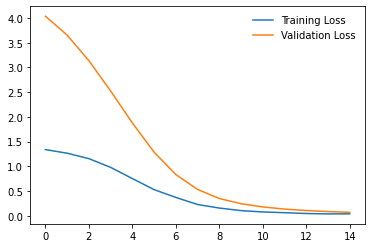

In [10]:
# train the custom model
model = train_model(5)

In [11]:
# save the custom model
torch.save(model, 'activity_classifier_model.pth')

Reload the model and evaluate it against a testset of images

In [12]:
# instantiate a transformer for the test images
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()])

In [13]:
# load the saved model
model = torch.load('activity_classifier_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# create a function that classifies an image and returns the index
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [15]:
# create a function gets a specified number of random images
def get_random_images(num):
    data = datasets.ImageFolder(path, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler,
                                         batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

0
0
0
0
1


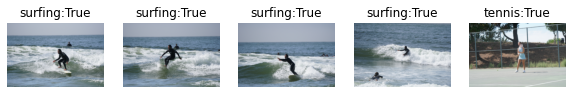

In [16]:
# run the model and plot the results
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(5)

fig = plt.figure(figsize=(10, 10))
for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    print(index)
    sub = fig.add_subplot(1, len(images), i+1)
    res = int(labels[i]) == index
    sub.set_title(str(classes[index]) + ':' + str(res))
    plt.axis('off')
    plt.imshow(image);